In [1]:
from functools import cache
from collections import defaultdict, Counter
import networkx as nx
import re

import pandas as pd
import numpy as np

from vincenty import vincenty
from scipy.spatial import Delaunay

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from tqdm.auto import tqdm

In [3]:
from ipa_parser.IPAParser_3_0 import IPAParser

In [4]:
def load_cldf_dataset(path_to_values, path_to_languages):
    values = pd.read_csv(path_to_values)
    languages = pd.read_csv(path_to_languages)
    return pd.merge(left = values, right = languages, how="left",
                    left_on="Language_ID", right_on="ID")

In [5]:
def get_frequencies_w_inventory_collapsing(dataset):
    glottocode_to_inventory = defaultdict(set)
    for row in dataset.itertuples():
        if not pd.isnull(row.Language_ID):
            glottocode_to_inventory[row.Language_ID].add(row.Value)
    print(f'{len(glottocode_to_inventory)} languages')
    frequencies_absolute = Counter()
    for segments in glottocode_to_inventory.values():
        for segment in segments:
            frequencies_absolute[segment] += 1
    frequencies_relative = {
        segment: count / len(glottocode_to_inventory)
        for segment, count in frequencies_absolute.items()
    }
    return frequencies_absolute, frequencies_relative

In [6]:
segbo = load_cldf_dataset('../data/segbo/cldf/values.csv',
                          '../data/segbo/cldf/languages.csv')
phoible = load_cldf_dataset('../data/phoible/cldf/values.csv',
                            '../data/phoible/cldf/languages.csv')

In [7]:
phoible_languages = pd.read_csv('../data/phoible/cldf/languages.csv')

# Filter out languages without glottocodes and coordinates
not_na = lambda x: not pd.isna(x)
phoible_languages = phoible_languages.loc[
    phoible_languages['Glottocode'].map(not_na) &
    phoible_languages['Latitude'].map(not_na) &
    phoible_languages['Longitude'].map(not_na)
]
phoible_languages.index = phoible_languages['Glottocode']

phoible_languages_filtered = set(phoible_languages.Glottocode)
phoible = phoible.loc[ phoible.Glottocode.map(lambda gltc: gltc in phoible_languages_filtered) ]

In [8]:
phoible_langs = set(phoible.Language_ID)
segbo = segbo.loc[ segbo.Language_ID.map(lambda gltc: gltc in phoible_langs) ]

## Construct the graph

In [9]:
# http://earthpy.org/tag/scipy.html
def lat_lon_to_cartesian(lat, lon, R = 1):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x = R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return (x,y,z)

In [10]:
def plot_graph(G_loc, coords_dict, figsize=(16,10)):
    # Create points
    lats = []
    lons = []
    for lang, coords_tuple in coords_dict.items():
        if lang in G_loc.nodes():
            lat, lon = coords_tuple
            lats.append(lat)
            lons.append(lon)

    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    plt.plot(lons, lats, marker='o', color='red', markersize=2,
              transform=ccrs.PlateCarree(), linewidth=0)
    
    # Create a line collection from the graph
    rev_t = lambda tpl: (tpl[1], tpl[0])
    lines = [[] for i in range(len(G_loc.edges()))]
    for i, edge in enumerate(G_loc.edges()):
        t, h = edge
        lines[i] = [
            rev_t(coords_dict[t]),
            rev_t(coords_dict[h])
        ]
    lc = LineCollection(lines, colors='brown', linewidths=0.5)
    _ = ax.add_collection(lc)

In [11]:
coords_dict = {}
for row in phoible_languages.itertuples():
    coords_dict[row.Glottocode] = (row.Latitude, row.Longitude)

cartesian_coords_dict = {
    k: lat_lon_to_cartesian(*v) for k, v in coords_dict.items()
}

name_arr = sorted(coords_dict)
name_dict = {
    name: i for i, name in enumerate(name_arr)
}
points_arr = [cartesian_coords_dict[lang] for lang in name_arr]

In [12]:
tri = Delaunay(points_arr)
indptr, indices = tri.vertex_neighbor_vertices

In [13]:
G = nx.Graph()
for k in range(len(indptr)-1):
    point_gltc = name_arr[k]
    G.add_node(point_gltc)
    neighbours = indices[indptr[k]:indptr[k+1]]
    for neighbor in neighbours:
        neigh_gltc = name_arr[neighbor]
        if vincenty(
            coords_dict[point_gltc],
            coords_dict[neigh_gltc]
        ) <= 500:
            G.add_edge(point_gltc, neigh_gltc)

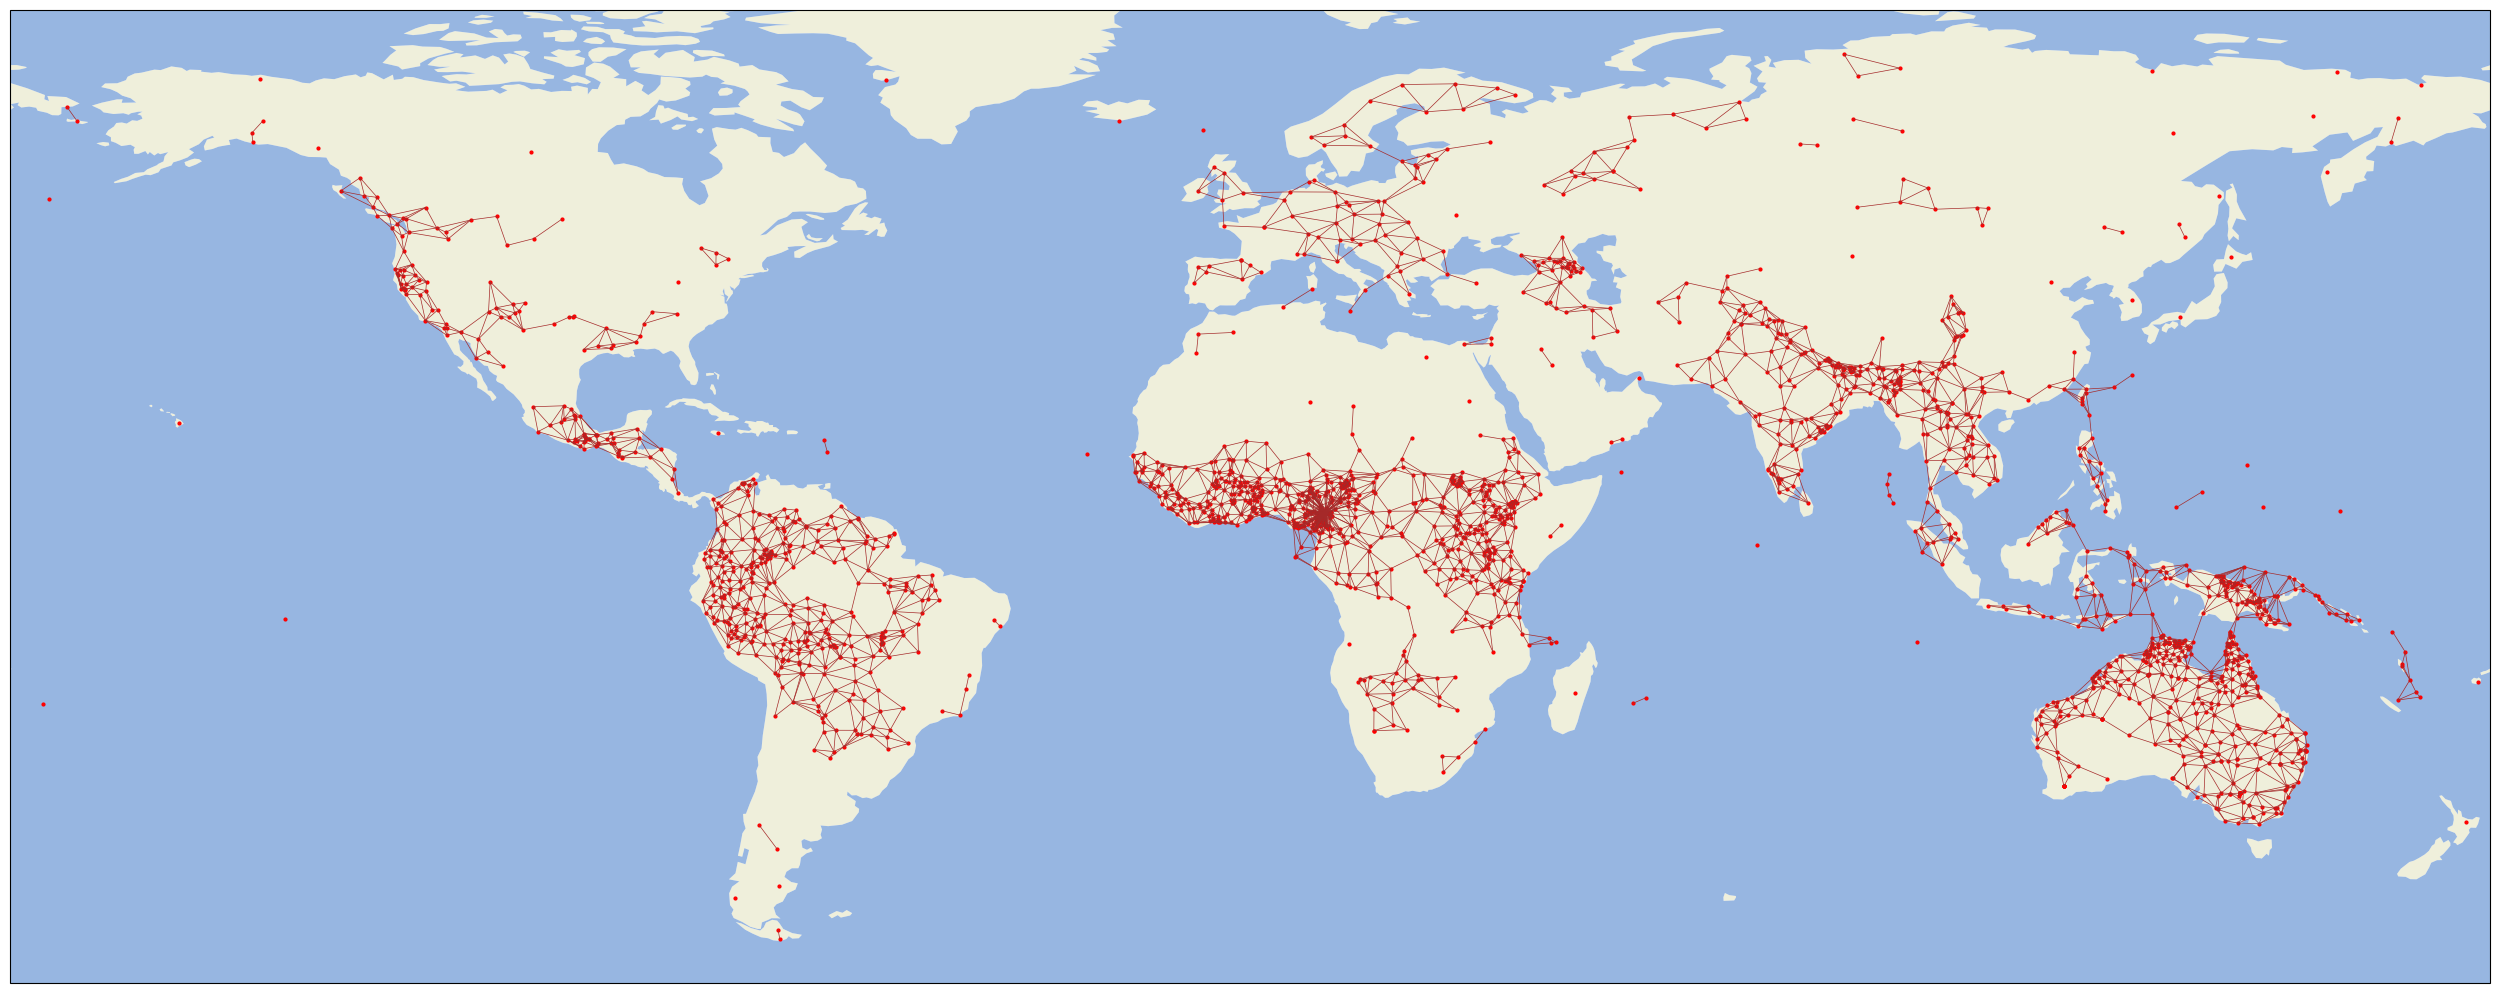

In [14]:
plot_graph(G, coords_dict, (32,20))

In [15]:
# Enrich the graph with new edges:
# connect with major languages all languages
# that borrowed segments from them together
# with their neighbours.
colonial = ['stan1288', 'stan1293', 'arab1395',
            'indo1316', 'russ1263', 'macr1272',
            'stan1290', 'dutc1256']

In [16]:
# The enrichment loop
for row in segbo.itertuples():
    gltc = row.Glottocode
    if gltc not in G.nodes():
        continue
    slgltcs_str = row.Source_Language_ID
    if pd.isna(slgltcs_str) or \
    slgltcs_str == 'unknown' or \
    slgltcs_str == '':
        continue
    slgltcs = re.split(r',\s*', slgltcs_str)
    for slgltc in slgltcs:
        if slgltc not in G.nodes():
            continue
        G.add_edge(gltc, slgltc)
        # For languages borrowing from colonial languages,
        # also connect their neighbours to the donour.
        if slgltc in colonial:
            try:
                for ngltc in G.neighbors(gltc):
                    G.add_edge(ngltc, slgltc)
            except KeyError:
                continue

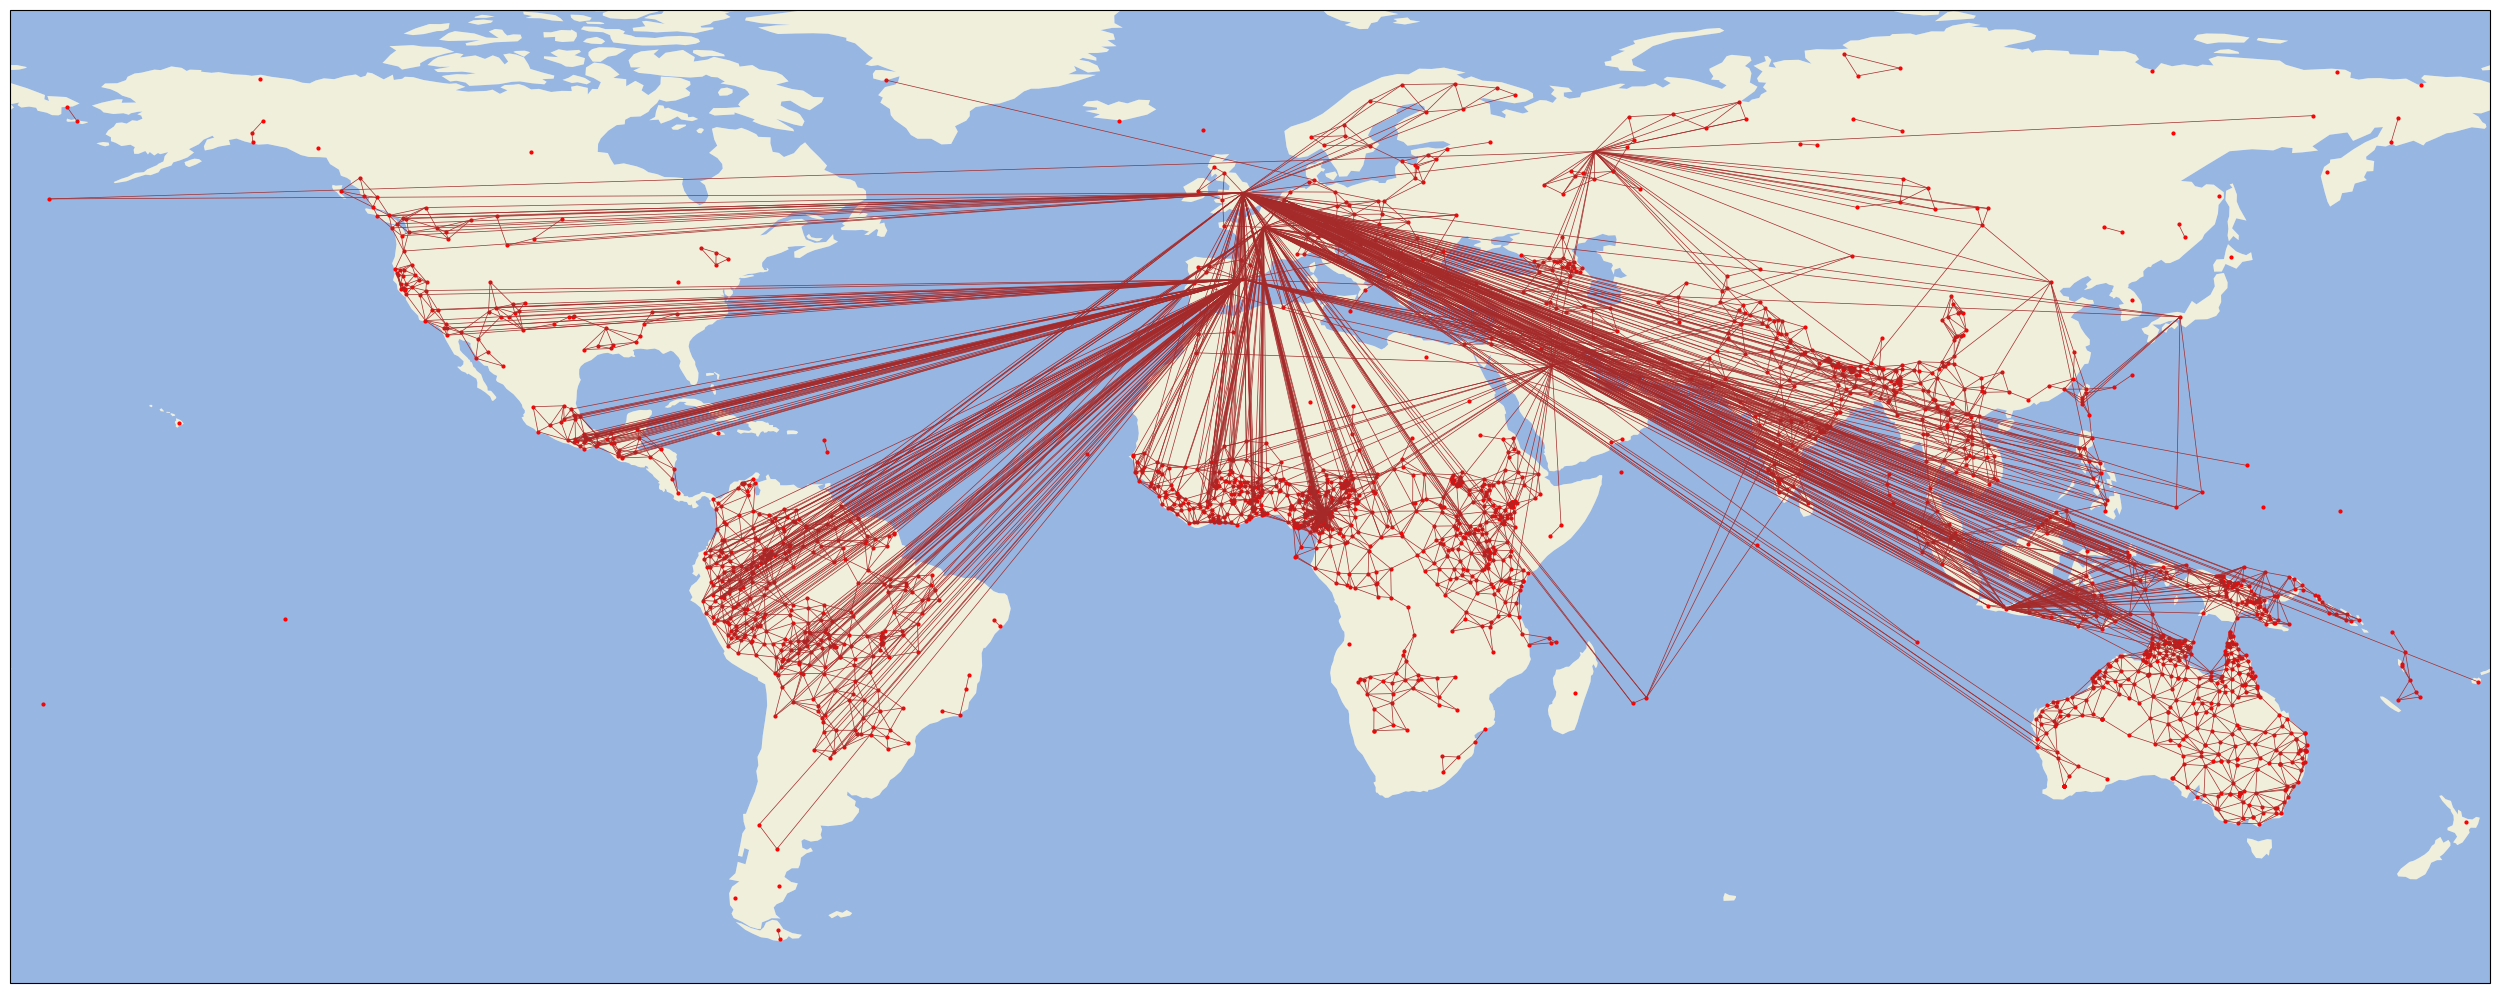

In [17]:
plot_graph(G, coords_dict, (32,20))

In [18]:
def track_borrowings(segment_, segbo_, phoible_, inventories_, borrowing_langs_, all_langs_, G_):
    '''
    Returns a list of tuples (gltc, potential_borrowing, borrowing_took_place)
    '''
    result = []
    if segment_ not in borrowing_langs_:
        raise IndexError(f'{segment_} is missing from the dataset.')
    # The test set consists of
    # (1) languages that don't have the segment
    no_seg = set(all_langs_) - set(
        phoible_.loc[phoible_.Value == segment_].Glottocode)
    # (2) languages that borrowed the segment
    test_set = no_seg.union(
        set(segbo_.loc[segbo_.Value == segment_].Glottocode))
    test_set = set([el for el in test_set if G_.has_node(el)])
    
    for gltc in test_set:
        exposure_count = 0
        for neighbor in G_.neighbors(gltc):
            # We exclude languages that eventually borrowed the segment.
            if neighbor in test_set:
                continue
            if segment_ in inventories_[neighbor]:
                exposure_count += 1
                if gltc in borrowing_langs_[segment_]:
                    result.append((gltc, segment_, 1))
                    break
        else:
            if exposure_count > 0:
                result.append((gltc, segment_, 0))
    return result

In [19]:
all_langs = phoible.Glottocode.unique()
len(all_langs)

2174

In [20]:
# Put langs' inventories into sets for quick access
inventories = defaultdict(set)
for i, row in phoible.iterrows():
    inventories[row.Glottocode].add(row.Value)

In [21]:
# Put langs that borrowed particular segments into sets
borrowing_langs = defaultdict(set)
for target_segment in segbo.Value.unique():
    for gltc in segbo.loc[
        segbo.Value == target_segment
    ].Glottocode.unique():
        borrowing_langs[target_segment].add(gltc)

In [22]:
result = []
for target_segment in borrowing_langs:
    result.extend(track_borrowings(target_segment, segbo, phoible, inventories, borrowing_langs, all_langs, G))

In [23]:
stats = defaultdict(Counter)
for _, target_segment, outcome in result:
    stats[target_segment]['exposure'] += 1
    stats[target_segment]['borrowed'] += outcome

In [24]:
ipa_parser_instance = IPAParser()
parses = {}
for target_segment in stats:
    parses[target_segment] = ipa_parser_instance.parse(target_segment).as_dict()

/mnt/d/YandexDisk/Analyses/borrowability-on-features/src


In [25]:
@cache
def parse_segment(segment):
    return ipa_parser_instance.parse(segment).as_dict()


@cache
def is_consonant(segment):
    try:
        return parse_segment(segment)['type'] == 'consonant'
    except:
        # Skipping unsupported segments
        return False


@cache
def extract_base_features(segment):
    parse_dict = parse_segment(segment)
    if parse_dict['lateral']:
        manner = f'manner:lateral_{parse_dict["manner"]}'
    elif parse_dict['nasal']:
        manner = f'manner:nasal_{parse_dict["manner"]}'
    else:
        manner = f'manner:{parse_dict["manner"]}'

    place = f'place:{parse_dict["place"]}'
    voice = f'voice:{parse_dict["voice"]}'

    # TODO: secondary articulations

    return [place, manner, voice]

In [26]:
# For each exposure event, we record the features of the target segment (consonants only)
# as well as counts of all features present in the borrowing inventory.
data_dict = defaultdict(lambda: defaultdict(int))
for gltc, target_segment, outcome in tqdm(result):
    key = f'{gltc}_{target_segment}'
    if not is_consonant(target_segment):
        continue
    for target_segment_feature in extract_base_features(target_segment):
        data_dict[key]['new_' + target_segment_feature] = 1
    for old_segment in inventories[gltc]:
        if is_consonant(old_segment):
            for target_segment_feature in extract_base_features(old_segment):
                data_dict[key]['old_' + target_segment_feature] += 1
    data_dict[key]['outcome'] = outcome

  0%|          | 0/57869 [00:00<?, ?it/s]

In [27]:
result_df = pd.DataFrame.from_dict(data_dict, orient='index').fillna(0).astype('int')
result_df.shape

(37913, 60)

In [28]:
result_df.outcome.value_counts()

outcome
0    37152
1      761
Name: count, dtype: int64

In [29]:
result_df.iloc[:5, :5]

,new_place:postalveolar,new_manner:affricate,new_voice:voiced,old_place:alveolar,old_manner:tap
chim1309_d̠ʒ,1,1,1,6,1
kway1241_d̠ʒ,1,1,1,5,0
jica1244_d̠ʒ,1,1,1,0,0
yape1248_d̠ʒ,1,1,1,7,0
tani1257_d̠ʒ,1,1,1,4,1


In [30]:
result_df = result_df[sorted(result_df.columns)]
result_df.to_csv('borrowing_w_features_detailed.csv')

In [31]:
# We now construct another dataset where borrower-language features
# are tracked according to whether they are present in the target segment.
# For each of place, manner, and voicing, we find the corresponding value
# in the borrower-language's inventory.

data_dict_small = defaultdict(lambda: defaultdict(int))
for gltc, target_segment, outcome in tqdm(result):
    if not is_consonant(target_segment):
        continue
    key = f'{gltc}_{target_segment}'
    for target_segment_feature, feature_label in zip(
        extract_base_features(target_segment),
        ['place', 'manner', 'voice']
    ):
        data_dict_small[key][target_segment_feature] = 1
        for old_segment in inventories[gltc]:
            if is_consonant(old_segment):
                for existing_segment_feature in extract_base_features(old_segment):
                    if existing_segment_feature == target_segment_feature:
                        data_dict_small[key][f'same_{feature_label}'] += 1
    data_dict_small[key]['outcome'] = outcome

  0%|          | 0/57869 [00:00<?, ?it/s]

In [32]:
result_df_small = pd.DataFrame.from_dict(data_dict_small, orient='index').fillna(0).astype('int')
result_df_small.shape

(37913, 31)

In [33]:
result_df_small.to_csv('borrowing_w_features_small.csv')